# NOTEBOOK DEEPSEEK - MULTICLASS CLASSIFICATION AND MITIGATION GENERATION (FINE-TUNING)

This notebook evaluates the DeepSeek LLM using fine-tuning for two tasks:
- Multiclass classification of network attacks.
- Generation of specific mitigations based on the identified attack type.

## 1. OBJECTIVES

The objective of this notebook is to evaluate the performance of the DeepSeek LLM in a **fine-tuned multiclass classification** setting, followed by **mitigation generation** based on the identified attack type.

Specifically, this notebook aims to:
- Assess the model's ability to classify logs into multiple attack categories after fine-tuning on labeled data.
- Generate appropriate mitigation strategies for each predicted attack.
- Evaluate the model's potential for automated threat response in IoT systems.

## 2. IMPORTS AND SETUP
Import the required python libraries, preprocessing, training (fine-tuning) and evaluation.

In [1]:
# pandas, json, re, tqdm and os imports
import pandas as pd
import json
import os
import re
from tqdm import tqdm
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# imports for LLM training
from datasets import Dataset, DatasetDict
from huggingface_hub import interpreter_login
from transformers import (
    TrainingArguments
)
from trl import SFTTrainer
from unsloth import FastLanguageModel, is_bfloat16_supported
# imports for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer

# Login to Hugging Face Hub
interpreter_login()

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



## 3. PREPARE DATASET

The dataset is split into 70% for training, and 30% for testing. Due to GPU memory limitations, the model is fine-tuned using only the training set, without intermediate evaluation on the validation set. After fine-tuning, the model is evaluated on the test set to assess its performance.

In [2]:
# Define file path
file_path = "../../../data/prompts/multiclass_instructions_with_mitigations.jsonl"

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# Read JSONL file line by line
samples = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        sample = json.loads(line.strip())  # Load each line as a JSON object
        samples.append({"text": sample["Prompt"]})  # Extract the prompt field

# Convert into Hugging Face Dataset format
dataset_dict = {"full": Dataset.from_list(samples)}
dataset = DatasetDict(dataset_dict)

# Verify first example
print(dataset["full"][0])

{'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.\n### Instruction:\nYou are a cybersecurity expert specializing in IoT security. Your task is to analyze network logs and determine whether the given log data indicates a potential attack. Only provide the type of attack if it is an attack. If the log data is normal traffic, state that it is normal traffic. If it is an attack, also include 4 to 5 specific technical mitigations.\n### Question:\n- The length of the DNS query is: 0.0\n- The MQTT protocol name used is: 0.0\n- The MQTT message type is: 0.0\n- The MQTT topic is: 0.0\n- The MQTT connection acknowledgment flags are: 0.0\n- TCP options set in the packet are: 0101080a9eb23b7d9b24a80c\n- TCP destination port is: 44090.0\n### Res

In [3]:
# Shuffle the dataset
dataset = dataset["full"].shuffle(seed=42)

# Split dataset into train (70%), test (30%)
train_size = int(0.7 * len(dataset))

# Ensure the split sizes are correct
train_dataset = dataset.select(range(train_size))
test_dataset = dataset.select(range(train_size, len(dataset)))

# Print sizes
print(f"Train Samples: {len(train_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

Train Samples: 10500
Test Samples: 4500


## 4. PREPARE LLM

Load the DeepSeek language model from Unsloth with specific configuration parameters for fine-tuning.

In [4]:
# Define model loading parameters
max_seq_length = 2048 
dtype = None 
load_in_4bit = True

# Load the DeepSeek LLM with Unsloth's FastLanguageModel utility
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/DeepSeek-R1-Distill-Llama-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4060 Laptop GPU. Max memory: 7.996 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [5]:
# Calculate the number of tokens in each example
def count_tokens(example):
    return {"num_tokens": len(tokenizer(example["text"])["input_ids"])}

# Add the column with the number of tokens to the dataset
train_dataset = train_dataset.map(count_tokens)

# View statistics of the number of tokens
num_tokens_list = train_dataset["num_tokens"]
print("Statistics of the number of tokens in the training dataset:")
print(pd.Series(num_tokens_list).describe())

# View large examples
too_long = train_dataset.filter(lambda x: x["num_tokens"] > max_seq_length)
print(f"\There are {len(too_long)} examples that exceed {max_seq_length} tokens.")
train_dataset = train_dataset.remove_columns(["num_tokens"])


<>:15: SyntaxWarning: invalid escape sequence '\T'
<>:15: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_307698/162708914.py:15: SyntaxWarning: invalid escape sequence '\T'
  print(f"\There are {len(too_long)} examples that exceed {max_seq_length} tokens.")
Map: 100%|██████████| 10500/10500 [00:12<00:00, 859.83 examples/s]


Statistics of the number of tokens in the training dataset:
count    10500.000000
mean       345.490762
std         45.863073
min        222.000000
25%        331.000000
50%        343.000000
75%        351.000000
max        452.000000
dtype: float64


Filter: 100%|██████████| 10500/10500 [00:00<00:00, 218018.59 examples/s]

\There are 0 examples that exceed 2048 tokens.


In [6]:
# Get the model's config
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj", "gate_proj",
        "up_proj", "down_proj"
    ],
    lora_alpha=16,
    lora_dropout=0,  
    bias="none",
    use_gradient_checkpointing="unsloth",  
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

# Reach the model for training
FastLanguageModel.for_training(model)

Unsloth 2025.2.15 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

## 5. PREPARE DATASET WITH EOS

In this section, each sample in the dataset is formatted to include an end-of-sentence (EOS) token.  
This ensures proper termination of sequences during training and improves model understanding of prompt boundaries.

In [7]:
EOS_TOKEN = tokenizer.eos_token  # Ensure each training sample has an EOS token

# Formatting function to structure data properly
def formatting_prompts_func(examples):
    texts = []
    for entry in examples["text"]:  # "text" is the key in our dataset
        text = entry + EOS_TOKEN  # Append EOS token
        texts.append(text)
    return {"text": texts}

# Apply formatting
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
test_dataset = test_dataset.map(formatting_prompts_func, batched=True)

# Print an example formatted sample
print(train_dataset["text"][0])

Map: 100%|██████████| 4500/4500 [00:00<00:00, 95745.31 examples/s]

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.
### Instruction:
You are a cybersecurity expert specializing in IoT security. Your task is to analyze network logs and determine whether the given log data indicates a potential attack. Only provide the type of attack if it is an attack. If the log data is normal traffic, state that it is normal traffic. If it is an attack, also include 4 to 5 specific technical mitigations.
### Question:
- The length of the DNS query is: 0.0
- The MQTT protocol name used is: 0.0
- The MQTT message type is: 0.0
- The MQTT topic is: 0.0
- The MQTT connection acknowledgment flags are: 0.0
- TCP options set in the packet are: 0101080a408622684a074d26
- TCP destination port is: 80.0
### Response:
<think>
This log 

## 6. INITIALIZE THE SFTTrainer FOR FINE-TUNING

This section initializes the `SFTTrainer` with the model, tokenizer, and prepared datasets.  
It sets training arguments such as learning rate, batch size, evaluation strategy, and checkpointing.  
The model will be fine-tuned using supervised learning and validated on the evaluation set.

In [8]:
# Prepare the trainer, with SFTTrainer and TrainingArguments
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    args=TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=630,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs_deepseek_mit",
        eval_strategy="no",  
        save_strategy="steps",  
        save_total_limit=2,  
        metric_for_best_model="eval_loss",  
        load_best_model_at_end=False,  
        greater_is_better=False,  
        eval_accumulation_steps=1,
    ),
    callbacks=[],  
)

Map (num_proc=2): 100%|██████████| 10500/10500 [00:08<00:00, 1272.51 examples/s]


## 7. TRAINING MODEL

In this section, the model is fine-tuned for up to 600 steps.  

In [9]:
# Start fine-tuning
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 10,500 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 4
\        /    Total batch size = 4 | Total steps = 630
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
10,1.987300
20,0.338900
30,0.186300
40,0.123800
50,0.088900
60,0.087600
70,0.085300
80,0.085600
90,0.097700
100,0.081300


In [10]:
# Save fine-tuned model and tokenizer
trainer.save_model("fine-tuned-model-attacks/deepseek_finetuned_model_multi_mit")  
tokenizer.save_pretrained("fine-tuned-model-attacks/deepseek_finetuned_model_multi_mit") 

('fine-tuned-model-attacks/deepseek_finetuned_model_multi_mit/tokenizer_config.json',
 'fine-tuned-model-attacks/deepseek_finetuned_model_multi_mit/special_tokens_map.json',
 'fine-tuned-model-attacks/deepseek_finetuned_model_multi_mit/tokenizer.json')

### TEST ONE RESPONSE

In [11]:
question = test_dataset["text"][5]
clean_question = re.split(r"This", question, maxsplit=1)[0].strip()

In [12]:
# Ensure the model is ready for inference
FastLanguageModel.for_inference(model)  # Activates Unsloth's optimized inference

# Tokenize the input log entry
inputs = tokenizer([clean_question], return_tensors="pt").to("cuda")

# Generate response from the fine-tuned model
outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1000, 
    use_cache=True,
)

# Decode and extract response
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print("Predicted response:",response[0].split("### Response:")[1].strip(), end='\n\n')
print("Actual response:",re.split(r"### Response:", question, maxsplit=1)[1].strip())

Predicted response: <think>
This log data is an attack!! The type of attack detected is Ransomware.

Mitigations:
- Implement multi-factor authentication (MFA) for all IoT edge devices and their associated management consoles to prevent unauthorized access.
- Restrict communication between IoT devices using firewalls or network segmentation to isolate components and reduce potential infection spread.
- Enforce secure software updates by using signed firmware only and verify integrity using hashes.
- Use monitoring tools to continuously check for suspicious activities, such as unusual network traffic or system behaviors indicative of ransomware activity.
</think>

Actual response: <think>
This log data is an attack!! The type of attack detected is Ransomware.

Mitigations:
- Implement multi-factor authentication (MFA) for all IoT edge devices and their associated management consoles to prevent unauthorized access.
- Restrict communication between IoT devices using firewalls or network s

## 8. COMPUTE PREDICTIONS

In this section, the LLM generates predictions for both the attack type and its corresponding mitigation strategy. The predicted attack labels and generated mitigations are stored in separate lists.

These predictions will be used later to compute evaluation metrics and analyze the model's performance.

In [13]:
FastLanguageModel.for_inference(model)

# Define attack types for mapping
attack_types = [
    "Normal", "DDoS_UDP", "DDoS_ICMP", "SQL_injection", "Password",
    "Vulnerability_scanner", "DDoS_TCP", "DDoS_HTTP", "Uploading", "Backdoor",
    "Port_Scanning", "XSS", "Ransomware", "MITM", "Fingerprinting"
]

attack_type_to_id = {attack: i for i, attack in enumerate(attack_types)}
id_to_attack_type = {i: attack for i, attack in enumerate(attack_types)}

# Extract the attack type from the <think> section
def extract_attack_from_think(text):
    match = re.search(r"The type of attack detected is ([A-Za-z0-9_]+)", text)
    if match:
        return match.group(1)
    return "Normal"

# Extrcat the mitigations from the <think> section
def extract_mitigations_from_think(text):
    think_match = re.search(r"<think>(.*?)</think>", text, re.DOTALL | re.IGNORECASE)
    if not think_match:
        return text.strip()
    think_content = think_match.group(1)
    mit_match = re.search(r"Mitigations:\s*(.*)", think_content, re.DOTALL | re.IGNORECASE)
    if mit_match:
        return mit_match.group(1).strip()
    return think_content.strip()

# List to store results
results = []

for sample in tqdm(test_dataset, desc="Processing test samples", unit="sample"):
    full_text = sample["text"]

    # Separate input and expected response
    if "### Response:" in full_text:
        input_text, expected_response = full_text.split("### Response:")
        input_text = input_text.strip()
        expected_response = expected_response.strip()
    else:
        input_text = full_text.strip()
        expected_response = "Normal"

    # Obtain the expected attack and mitigation
    actual_attack = extract_attack_from_think(expected_response)
    actual_mitigation = extract_mitigations_from_think(expected_response)

    # Tokenize the input
    inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

    # Generate response from the model
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=1000,
        use_cache=True,
    )

    predicted_full = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Extract the predicted attack and mitigation
    predicted_attack = extract_attack_from_think(predicted_full)
    predicted_mitigation = extract_mitigations_from_think(predicted_full)

    # Save the results
    results.append({
        "attack_pred": predicted_attack,
        "attack_true": actual_attack,
        "mitigation_pred": predicted_mitigation,
        "mitigation_true": actual_mitigation
    })

Processing test samples: 100%|██████████| 4500/4500 [10:17:09<00:00,  8.23s/sample]  


## 9. Compute Evaluation Metrics

In this section, standard evaluation metrics are computed to assess the model's performance. These include Accuracy, Precision, Recall, F1-Score, and the Confusion Matrix.

In [14]:
# Store types of attack and the corresponding mitigations
mitigation_reference_dict = {}

with open("../../../data/capec/attack_mitigations.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        mitigation_reference_dict[entry["attack"]] = entry["mitigations"]

### GENERAL METRICS

In [ ]:
def evaluate_predictions(results, mitigation_reference_dict):
    # Extract attack predictions and ground truths
    y_pred_attack = [r["attack_pred"] for r in results]
    y_true_attack = [r["attack_true"] for r in results]

    # General classification metrics (attack detection)
    attack_metrics = {
        "accuracy": accuracy_score(y_true_attack, y_pred_attack),
        "precision": precision_score(y_true_attack, y_pred_attack, average="weighted", zero_division=0),
        "recall": recall_score(y_true_attack, y_pred_attack, average="weighted", zero_division=0),
        "f1": f1_score(y_true_attack, y_pred_attack, average="weighted", zero_division=0),
    }

    # Load embedding model and ROUGE scorer
    embed_model = SentenceTransformer('all-MiniLM-L6-v2')
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    # Initialize mitigation metric lists
    rougeL_scores = []
    cosine_similarities = []
    valid_flags = []  # Track which rows are evaluated

    for r in results:
        attack_pred = r["attack_pred"]
        pred_mit = r["mitigation_pred"]

        # Skip if predicted label is 'Normal' (no mitigation to evaluate)
        if attack_pred.lower() == "normal":
            rougeL_scores.append(None)
            cosine_similarities.append(None)
            valid_flags.append(False)
            continue

        # Get expected mitigation for the predicted attack
        true_mitigations = mitigation_reference_dict.get(attack_pred, [])
        true_mit = " ".join(true_mitigations) if true_mitigations else ""

        # Compute ROUGE-L F1 score
        rouge_score = rouge.score(true_mit, pred_mit)['rougeL'].fmeasure
        rougeL_scores.append(rouge_score)

        # Compute cosine similarity between predicted and expected mitigations
        emb_pred = embed_model.encode(pred_mit, convert_to_tensor=True)
        emb_true = embed_model.encode(true_mit, convert_to_tensor=True)
        cosine_score = util.cos_sim(emb_pred, emb_true).item()
        cosine_similarities.append(cosine_score)
        valid_flags.append(True)

    # Filter valid scores (exclude 'Normal' cases)
    valid_rouge = [s for s in rougeL_scores if s is not None]
    valid_cosine = [s for s in cosine_similarities if s is not None]

    # Average mitigation generation scores
    mitigation_metrics = {
        "rougeL_f1": sum(valid_rouge) / len(valid_rouge) if valid_rouge else 0,
        "cosine_similarity": sum(valid_cosine) / len(valid_cosine) if valid_cosine else 0
    }

    # Construct result DataFrame
    df_results = pd.DataFrame(results)
    df_results["rougeL"] = rougeL_scores
    df_results["cosine_similarity"] = cosine_similarities
    df_results["attack_correct"] = df_results["attack_true"] == df_results["attack_pred"]

    return attack_metrics, mitigation_metrics, df_results


In [21]:
# Run evaluation
attack_metrics, mitigation_metrics, df_eval = evaluate_predictions(results, mitigation_reference_dict)

# Print metrics
print("General Classification Metrics")

print("\nAttack Classification Metrics:")
for k, v in attack_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nMitigation Generation Metrics (based on predicted attack):")
for k, v in mitigation_metrics.items():
    print(f"{k}: {v:.4f}")

General Classification Metrics

Attack Classification Metrics:
accuracy: 0.7369
precision: 0.7409
recall: 0.7369
f1: 0.7371

Mitigation Generation Metrics (based on predicted attack):
rougeL_f1: 1.0000
cosine_similarity: 1.0000


### METRICS PER CLASS

In [22]:
def evaluate_predictions_by_class(results, mitigation_reference_dict):
    # Extract predictions and ground truths
    y_pred_attack = [r["attack_pred"] for r in results]
    y_true_attack = [r["attack_true"] for r in results]

    # General attack classification metrics
    attack_metrics = {
        "accuracy": accuracy_score(y_true_attack, y_pred_attack),
        "precision": precision_score(y_true_attack, y_pred_attack, average="weighted", zero_division=0),
        "recall": recall_score(y_true_attack, y_pred_attack, average="weighted", zero_division=0),
        "f1": f1_score(y_true_attack, y_pred_attack, average="weighted", zero_division=0),
    }

    # Detailed classification report
    attack_metrics_by_class = classification_report(
        y_true_attack,
        y_pred_attack,
        output_dict=True,
        zero_division=0
    )

    # Load embedding and ROUGE tools
    embed_model = SentenceTransformer('all-MiniLM-L6-v2')
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    # Metrics storage
    rougeL_scores = []
    cosine_similarities = []
    mitigation_by_predicted_type = []

    for r in results:
        attack_pred = r["attack_pred"]
        pred_mit = r["mitigation_pred"]

        # Skip evaluation if predicted class is 'Normal'
        if attack_pred.lower() == "normal":
            rougeL_scores.append(None)
            cosine_similarities.append(None)
            continue

        # Get expected mitigation for the predicted attack
        true_mitigations = mitigation_reference_dict.get(attack_pred, [])
        true_mit = " ".join(true_mitigations) if true_mitigations else ""

        # ROUGE-L
        rouge_score = rouge.score(true_mit, pred_mit)['rougeL'].fmeasure
        rougeL_scores.append(rouge_score)

        # Cosine similarity
        emb_pred = embed_model.encode(pred_mit, convert_to_tensor=True)
        emb_true = embed_model.encode(true_mit, convert_to_tensor=True)
        cosine_score = util.cos_sim(emb_pred, emb_true).item()
        cosine_similarities.append(cosine_score)

        # Store by predicted attack type
        mitigation_by_predicted_type.append({
            "attack_pred": attack_pred,
            "rouge": rouge_score,
            "cosine": cosine_score
        })

    # Filter out 'None' scores for aggregation
    valid_rouge = [s for s in rougeL_scores if s is not None]
    valid_cosine = [s for s in cosine_similarities if s is not None]

    mitigation_metrics = {
        "rougeL_f1": sum(valid_rouge) / len(valid_rouge) if valid_rouge else 0,
        "cosine_similarity": sum(valid_cosine) / len(valid_cosine) if valid_cosine else 0
    }

    # Mitigation scores by predicted class
    mitigation_by_class = {}
    for item in mitigation_by_predicted_type:
        attack = item["attack_pred"]
        if attack not in mitigation_by_class:
            mitigation_by_class[attack] = {"rouge": [], "cosine": []}
        mitigation_by_class[attack]["rouge"].append(item["rouge"])
        mitigation_by_class[attack]["cosine"].append(item["cosine"])

    mitigation_by_class = {
        k: {
            "rougeL_f1": sum(v["rouge"]) / len(v["rouge"]),
            "cosine_similarity": sum(v["cosine"]) / len(v["cosine"])
        }
        for k, v in mitigation_by_class.items()
    }

    # Final DataFrame
    df_results = pd.DataFrame(results)
    df_results["rougeL"] = rougeL_scores
    df_results["cosine_similarity"] = cosine_similarities
    df_results["attack_correct"] = df_results["attack_true"] == df_results["attack_pred"]

    return attack_metrics, attack_metrics_by_class, mitigation_metrics, mitigation_by_class, df_results


In [23]:
attack_metrics, attack_by_class, mit_metrics, mit_by_class, df_eval = evaluate_predictions_by_class(results, mitigation_reference_dict)

print("\nPer-Class Performance (Attack Classification):")
for label, metrics in attack_by_class.items():
    if label in attack_types: 
        print(f"{label:25s} F1={metrics['f1-score']:.4f} | Precision={metrics['precision']:.4f} | Recall={metrics['recall']:.4f}")

print("\nMitigation Quality per Predicted Attack Class:")
for attack, metrics in mit_by_class.items():
    print(f"{attack:25s} ROUGE-L={metrics['rougeL_f1']:.4f} | Cosine={metrics['cosine_similarity']:.4f}")


Per-Class Performance (Attack Classification):
Backdoor                  F1=0.9607 | Precision=0.9757 | Recall=0.9461
DDoS_HTTP                 F1=0.9865 | Precision=0.9932 | Recall=0.9799
DDoS_ICMP                 F1=0.3147 | Precision=0.2744 | Recall=0.3690
DDoS_TCP                  F1=0.5920 | Precision=0.5467 | Recall=0.6455
DDoS_UDP                  F1=0.2171 | Precision=0.2251 | Recall=0.2096
Fingerprinting            F1=0.3012 | Precision=0.3713 | Recall=0.2534
MITM                      F1=0.4320 | Precision=0.4193 | Recall=0.4455
Normal                    F1=0.9984 | Precision=1.0000 | Recall=0.9968
Password                  F1=0.9855 | Precision=0.9935 | Recall=0.9776
Port_Scanning             F1=0.5340 | Precision=0.5730 | Recall=0.5000
Ransomware                F1=0.8948 | Precision=0.8629 | Recall=0.9292
SQL_injection             F1=0.9897 | Precision=0.9931 | Recall=0.9863
Uploading                 F1=0.9114 | Precision=0.9216 | Recall=0.9015
Vulnerability_scanner     F1=

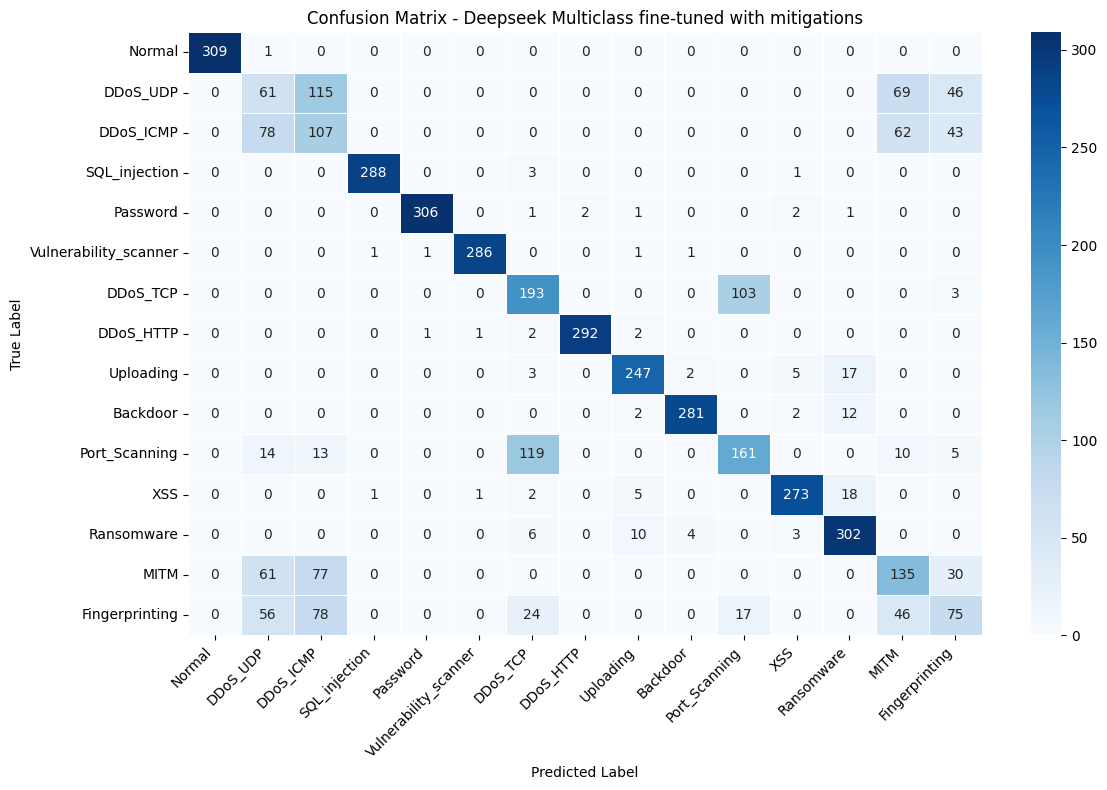

In [19]:
# Define the attack types for the confusion matrix
attack_types = [
    "Normal", "DDoS_UDP", "DDoS_ICMP", "SQL_injection", "Password",
    "Vulnerability_scanner", "DDoS_TCP", "DDoS_HTTP", "Uploading", "Backdoor",
    "Port_Scanning", "XSS", "Ransomware", "MITM", "Fingerprinting"
]

# Extract actual and predicted labels
actual_labels_str = [r["attack_true"] for r in results]
predictions_str = [r["attack_pred"] for r in results]

# Create the confusion matrix
cm = confusion_matrix(actual_labels_str, predictions_str, labels=attack_types)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=attack_types, columns=attack_types)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Deepseek Multiclass fine-tuned with mitigations")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
